# Downloading the data

In [ ]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('../data/steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

# Load Data and Figure settings

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
fname = []
for j in range(3):
  fname.append('../data/steinmetz_part%d.npz'%j)
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('../data/steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))
  
# @title Figure settings
from matplotlib import rcParams
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

# Extract and reshape relevant data

In [9]:

# session 35 neuron x trial x activation
data = alldat[35]['spks']
print(data.shape) # no puedo usar PCA es tridimensional, neurona x trial x activation

# agrupo por slots de tiempo
window_size = 10
stride = 1

num_windows = (data.shape[2] - window_size) // stride + 1

windowed_data = []

for i in range(num_windows):
    window_data = data[:, :, i * stride:i * stride + window_size]
    window_avg = np.mean(window_data, axis=2)
    windowed_data.append(window_avg)

data_avg = np.stack(windowed_data, axis=2)
print(data_avg.shape)
flattened_data = data_avg.reshape(data_avg.shape[0], -1)
print(flattened_data.shape)

(680, 258, 250)
(680, 258, 241)
(680, 62178)


# PCA

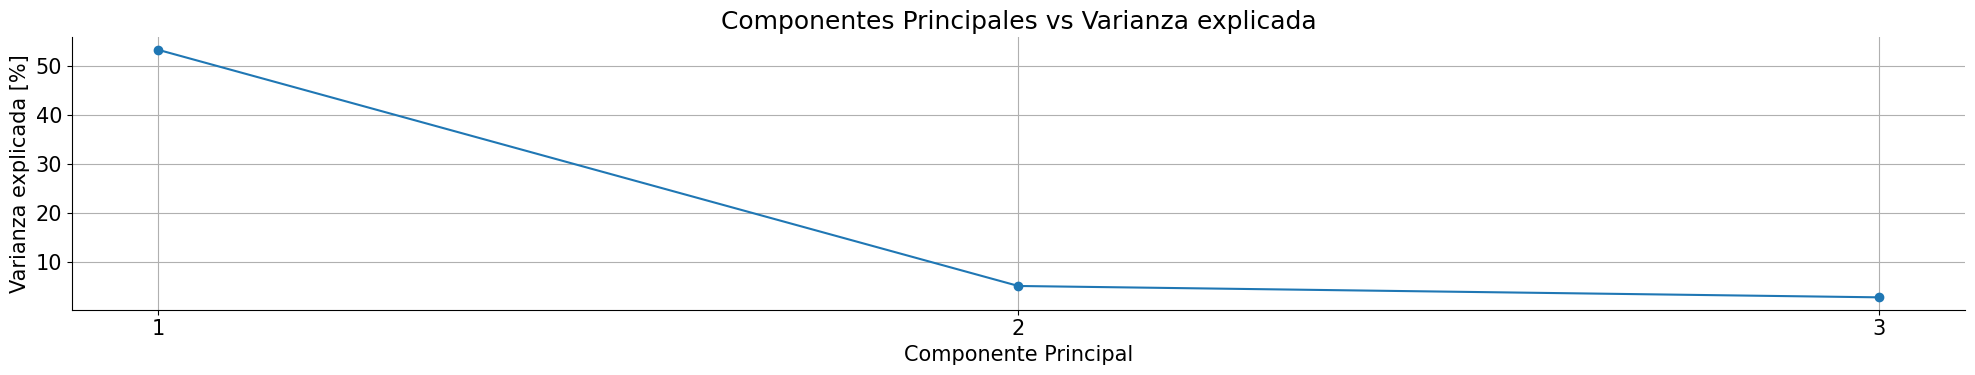

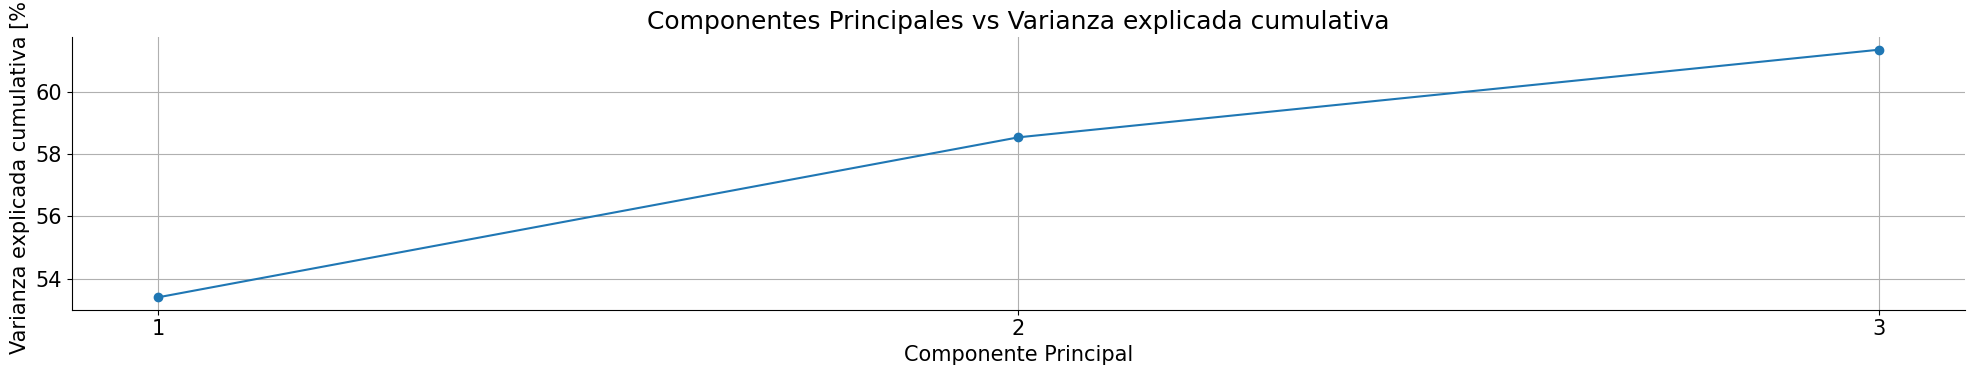

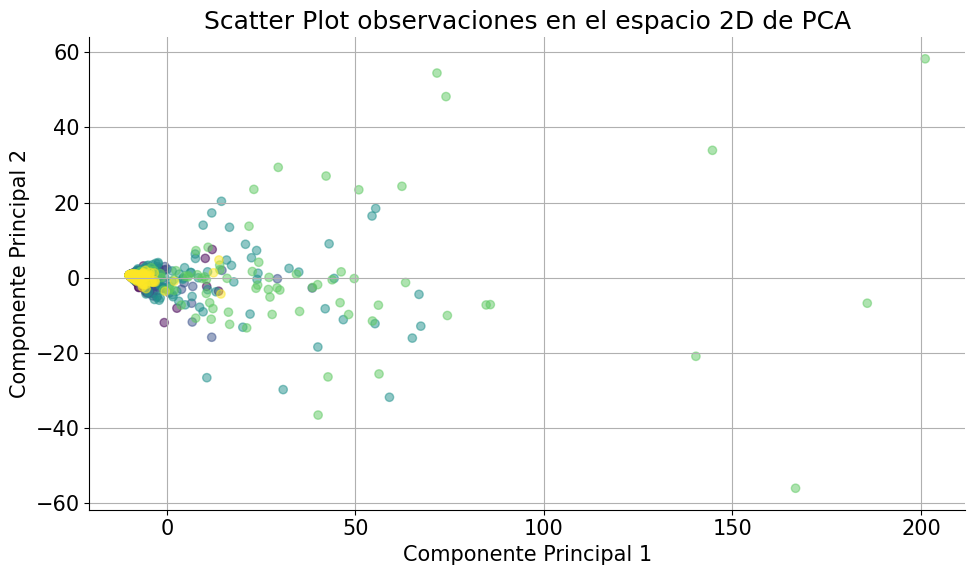

In [10]:

# 3 componentes
pca = PCA(3)
# mouse 1
pca_results = pca.fit_transform(flattened_data)
# Explained variance vs Principal component
explained_variance = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance) + 1), explained_variance*100, marker='o')
plt.xticks(range(1, len(explained_variance) +1))
plt.xlabel("Componente Principal")
plt.ylabel("Varianza explicada [%]")
plt.title("Componentes Principales vs Varianza explicada")
plt.grid(True)
plt.show()


cumulative_variance = np.zeros(explained_variance.shape)
for i in range(len(explained_variance)):
    for j in range(0, i+1):
        cumulative_variance[i] += explained_variance[j]

# Cumulative variance vs Principal component
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance*100, marker='o')
plt.xticks(range(1, len(cumulative_variance) +1))
plt.xlabel("Componente Principal")
plt.ylabel("Varianza explicada cumulativa [%]")
plt.title("Componentes Principales vs Varianza explicada cumulativa")
plt.grid(True)
plt.show()

# 10 colores
colores = [(i // (len(pca_results)//5)) + 1 for i in range(len(pca_results))]

# PC1 vs. PC2
plt.figure(figsize=(10, 6))
plt.scatter(pca_results[:, 0],  # PCA1
            pca_results[:, 1],  # PCA2 
            alpha=0.5,          # Transparencia 
            c=colores)          # asignacion de colores

plt.title('Scatter Plot observaciones en el espacio 2D de PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()


# TSNE

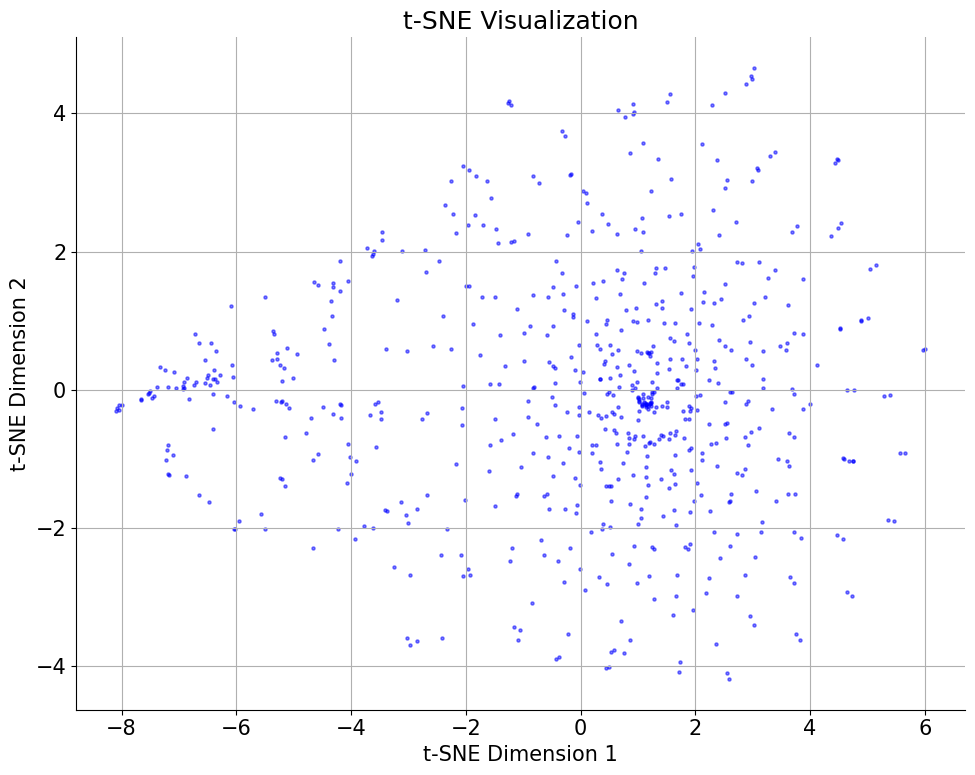

In [11]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(flattened_data)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=5, c='b', alpha=0.5)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

In [ ]:
# @title Basic plots of population average

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11]
print(dat.keys())

dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1, 5, 1)
response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response >= 0].mean(axis=(0, 1)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right == 0].mean(axis=(0, 1)))  # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel='time (sec)', ylabel='firing rate (Hz)')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'keys'